In [1]:
%load_ext autoreload
%autoreload 2

The equation we want to simulate is

$$
\left(\nabla^2 - \frac{\omega^2}{c^2} \right)u = - i\omega S_M
$$

Furthermore, to enforce the Sommerfield radiation conditions, the components of the spatial differential operators are modified as [[1]](http://oomph-lib.maths.man.ac.uk/doc/pml_helmholtz/scattering/latex/refman.pdf):

$$
\partial_{x_j} = \frac{\partial_{x_j}}{\gamma_j}
$$

where

$$
\gamma_j = 1 + \frac{\sigma_j(x)}{k_0}, \qquad \sigma_j(x) = \begin{cases}
\frac{\sigma^*\|x_j - \Delta_{PML}\|^\alpha}{\Delta_{PML}}, & \|x\| > \Delta_{PML}\\
0, & \text{otherwise} \\
\end{cases}$$

Let's start by building up the $\sigma$ function

## $\sigma$ function

In [1]:
from matplotlib import pyplot as plt

from jwave.geometry import Domain
from jwave import operators as jops
from jwave.core import operator
from jax import numpy as jnp
import jax

In [5]:
domain = Domain((1024,1024), (1., 1.))

In [6]:
from jwave.discretization import Coordinate
from jwave.core import Field

coordinate_discr = Coordinate(domain)
X = Field(coordinate_discr, params={}, name="X")

grid = coordinate_discr.get_field_on_grid()({})

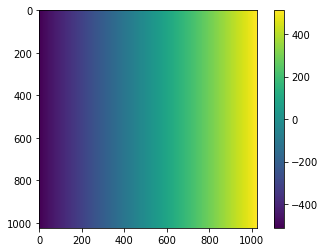

In [7]:
plt.imshow(grid[...,1])
plt.colorbar()

In [11]:
delta_pml = 512 - 20.

def sigma(X):
    on_pml = jops.elementwise(
        lambda x: jnp.where(
            jnp.abs(x) > delta_pml,
            (jnp.abs(jnp.abs(x)-delta_pml)/(64. - delta_pml)), 
            0.)
    )
    return 4*on_pml(X)**2

In [12]:
s = operator()(sigma)(X=X)
global_params = s.get_global_params()

# Can use directly this on a GridBased
PML = s.get_field_on_grid(0)(global_params, {'X': {}})

# Or can use the PML function
pml_f = lambda x: s.get_field(0)(global_params, {'X': {}}, x)

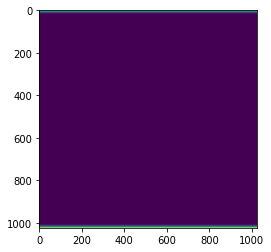

In [13]:
plt.imshow(PML[...,0])

# $\gamma$ function

Showing function composition

In [14]:
def grad_factor(X):
    return 1./(1 + 1j*sigma(X))

In [15]:
s = operator()(grad_factor)(X=X)
global_params = s.get_global_params()

# Can use directly this on a GridBased
PML = s.get_field_on_grid(0)(global_params, {'X': {}})

# Or can use the PML function
pml_f = lambda x: s.get_field(0)(global_params, {'X': {}}, x)

In [16]:
s

DiscretizedOperator :: [Arbitrary], ['_zY'] 

 Input fields: ('X',)

Globals: {'shared': {}, 'independent': {'PowerScalar_l5': {'scalar': 2}, 'MultiplyScalar_nR': {'scalar': 4}, 'MultiplyScalar_p2': {'scalar': 1j}, 'AddScalar_rE': {'scalar': 1}, 'MultiplyScalar_y7': {'scalar': 1.0}}}

Operations:
- _k5: Arbitrary <-- Elementwise ('X',) | (none) Elementwise
- _mO: Arbitrary <-- PowerScalar ('_k5',) | (independent) PowerScalar_l5
- _oj: Arbitrary <-- MultiplyScalar ('_mO',) | (independent) MultiplyScalar_nR
- _q2: Arbitrary <-- MultiplyScalar ('_oj',) | (independent) MultiplyScalar_p2
- _vm: Arbitrary <-- AddScalar ('_q2',) | (independent) AddScalar_rE
- _x9: Arbitrary <-- Reciprocal ('_vm',) | (none) Reciprocal
- _zY: Arbitrary <-- MultiplyScalar ('_x9',) | (independent) MultiplyScalar_y7

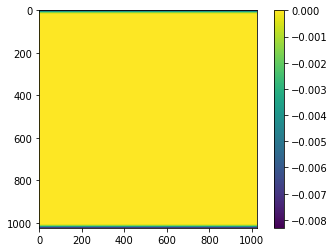

In [17]:
plt.imshow(PML[...,0].imag)
plt.colorbar()

# Modified $\nabla^2$ operator

In [18]:
from jwave.discretization import FourierSeries
fourier_discr = FourierSeries(domain)

u_fourier_params = fourier_discr.empty_field()

u_fourier_params = u_fourier_params.at[64,64].set(1. + 0j)
u_fourier = Field(fourier_discr, params=u_fourier_params, name='u')

pml = Field(fourier_discr, params=PML, name='pml')

In [21]:
grad = jops.gradient
diag_jacobian = jops.diag_jacobian

@operator()
def laplacian(u, pml):
    grad_u = jops.gradient(u)
    mod_grad_u = grad_u*pml
    mod_diag_jacobian = jops.diag_jacobian(mod_grad_u)*pml
    return jops.sum_over_dims(mod_diag_jacobian)

In [22]:
s = laplacian(u=u_fourier, pml=pml)
global_params = s.get_global_params()

# Can use directly this on a GridBased
from jax import jit
f = jit(s.get_field_on_grid(0))
field = f(global_params, {'u': u_fourier_params, "pml": PML})

In [23]:
s

DiscretizedOperator :: [FourierSeries], ['_vm'] 

 Input fields: ('u', 'pml')

Globals: {'shared': {'FFTGradient': {'k_vec': [DeviceArray([ 0.        ,  0.00613592,  0.01227185, ..., -0.01840777,
             -0.01227185, -0.00613592], dtype=float32), DeviceArray([ 0.        ,  0.00613592,  0.01227185, ..., -0.01840777,
             -0.01227185, -0.00613592], dtype=float32)]}, 'FFTDiagJacobian': {'k_vec': [DeviceArray([ 0.        ,  0.00613592,  0.01227185, ..., -0.01840777,
             -0.01227185, -0.00613592], dtype=float32), DeviceArray([ 0.        ,  0.00613592,  0.01227185, ..., -0.01840777,
             -0.01227185, -0.00613592], dtype=float32)]}}, 'independent': {}}

Operations:
- _k5: FourierSeries <-- FFTGradient ('u',) | (shared) FFTGradient
- _mO: FourierSeries <-- MultiplyOnGrid ('_k5', 'pml') | (none) MultiplyOnGrid
- _oj: FourierSeries <-- FFTDiagJacobian ('_mO',) | (shared) FFTDiagJacobian
- _q2: FourierSeries <-- MultiplyOnGrid ('_oj', 'pml') | (none) MultiplyOnGrid
-

In [34]:
%%timeit
field = f(global_params, {'u': u_fourier_params, "pml": PML}).block_until_ready()

1.17 ms ± 397 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


/home/antonios/anaconda3/envs/jwave/lib/python3.8/site-packages/jax/interpreters/xla.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


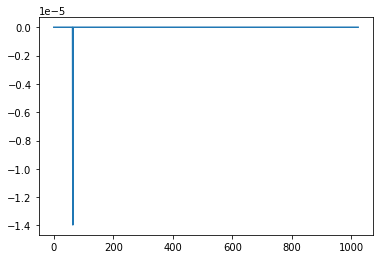

In [36]:
plt.plot(field[512])

In [30]:
s

DiscretizedOperator :: [FourierSeries], ['_vm'] 

 Input fields: ('u', 'pml')

Globals: {'shared': {'FFTGradient': {'k_vec': [DeviceArray([ 0.        ,  0.04908739,  0.09817477,  0.14726216,
              0.19634955,  0.24543694,  0.2945243 ,  0.34361172,
              0.3926991 ,  0.44178647,  0.49087387,  0.5399613 ,
              0.5890486 ,  0.638136  ,  0.68722343,  0.7363108 ,
              0.7853982 ,  0.8344856 ,  0.88357294,  0.93266034,
              0.98174775,  1.0308352 ,  1.0799226 ,  1.1290098 ,
              1.1780972 ,  1.2271847 ,  1.276272  ,  1.3253595 ,
              1.3744469 ,  1.4235342 ,  1.4726216 ,  1.521709  ,
              1.5707964 ,  1.6198838 ,  1.6689712 ,  1.7180586 ,
              1.7671459 ,  1.8162333 ,  1.8653207 ,  1.9144081 ,
              1.9634955 ,  2.0125828 ,  2.0616703 ,  2.1107576 ,
              2.159845  ,  2.2089324 ,  2.2580197 ,  2.3071072 ,
              2.3561945 ,  2.405282  ,  2.4543693 ,  2.5034568 ,
              2.552544  ,  2.